<a href="https://colab.research.google.com/github/LMBTough/NIB/blob/main/colab/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/LMBTough/NIB.git

Cloning into 'NIB'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 142 (delta 59), reused 109 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 11.93 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
!pip install grad-cam
!pip install clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir("/content/NIB")
import torch
from scripts.plot import visualize_vandt_heatmap
from salicncy import chefer,fast_ig,gradcam,m2ib,mfaba,nib,rise,saliencymap
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast
from PIL import Image, ImageOps
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def plot(tokenizer,processor, image_path, text, vmap, tmap, bb=None):
    # Preprocess image
    image = Image.open(image_path).convert('RGB')
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    if bb:
        scaled_bb = []
        for x, y, w, h in bb:
            hr, vr = image_under.shape[0]/image.size[0], image_under.shape[1]/image.size[1]
            scaled_bb.append((x*hr, y*vr, w*hr, h*vr))
        bb = scaled_bb
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under, bb=bb)

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Visualize

In [6]:
def generate_plot(img_path,text,method):
    image = Image.open(img_path).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device)
    image_features = model.get_image_features(image_feat)
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    text_features = model.get_text_features(text_ids)

    if method in [chefer,fast_ig,gradcam,mfaba,saliencymap]:
        vmap, tmap = method(model, processor, [text], [image])
    elif method == rise:
        vmap, tmap = rise(model, image_feat,[text_ids],image_features,text_features)
        tmap = [tmap[0].detach().cpu().numpy()]
    elif method == m2ib:
        vmap, tmap = m2ib(model, [text_ids], image_feat, 0.1)
    elif method == nib:
        vmap, tmap = nib(model, [text_ids], image_feat,10, 9)
    if vmap.shape[1] == 3:
        vmap = vmap.mean(1)
    plot(tokenizer, processor, img_path, text, vmap.squeeze(), tmap[0])

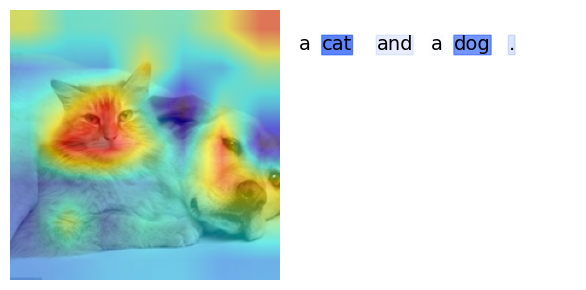

In [7]:
img_path = "images/cat-dog.jpg"
text = "a cat and a dog."

generate_plot(img_path,text,nib)

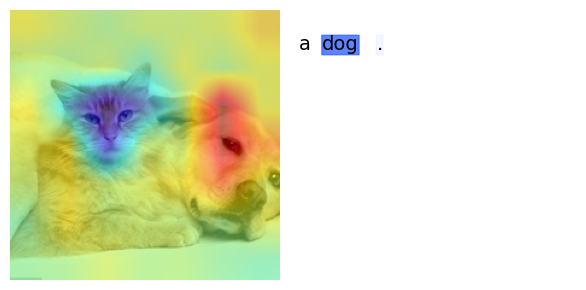

In [8]:
text = "a dog."
generate_plot(img_path,text,nib)

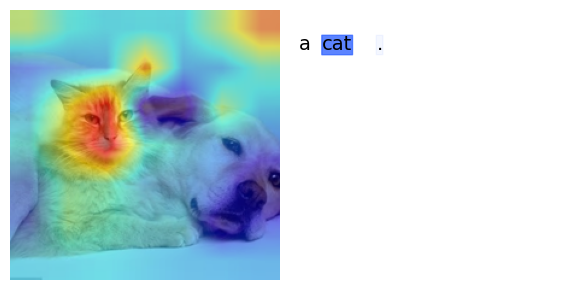

In [9]:
text = "a cat."
generate_plot(img_path,text,nib)